In [10]:
!pip install ultralytics opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git


Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800 (from 1)
Receiving objects: 100% (800/800), 7.39 MiB | 25.05 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [3]:
!unzip -q BCCD_Dataset/BCCD.v1-voc.zip -d BCCD_Dataset


unzip:  cannot find or open BCCD_Dataset/BCCD.v1-voc.zip, BCCD_Dataset/BCCD.v1-voc.zip.zip or BCCD_Dataset/BCCD.v1-voc.zip.ZIP.


In [4]:
!mkdir -p data/images/train data/images/val data/labels/train data/labels/val


In [5]:
!mv BCCD_Dataset/BCCD/JPEGImages/* data/images/train/
!mv BCCD_Dataset/BCCD/Annotations/* data/labels/train/


In [6]:
import os
import glob
import xml.etree.ElementTree as ET

# Define class names for YOLO
classes = ["WBC", "RBC", "Platelets"]

def convert_voc_to_yolo(xml_file, txt_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    with open(txt_file, "w") as f:
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name not in classes:
                continue
            class_id = classes.index(class_name)
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            # Convert to YOLO format
            x_center = (xmin + xmax) / (2 * width)
            y_center = (ymin + ymax) / (2 * height)
            w = (xmax - xmin) / width
            h = (ymax - ymin) / height

            f.write(f"{class_id} {x_center} {y_center} {w} {h}\n")

# Convert all annotations
xml_files = glob.glob('data/labels/train/*.xml')
for xml_file in xml_files:
    txt_file = xml_file.replace('.xml', '.txt')
    convert_voc_to_yolo(xml_file, txt_file)
    os.remove(xml_file)  # Remove original XML files


In [7]:
import os
import glob
import shutil
import random

# Define the split ratio
train_ratio = 0.8
val_ratio = 0.2

# Get a list of all image files
image_files = glob.glob('data/images/train/*')

# Shuffle the image files randomly
random.shuffle(image_files)

# Calculate the split index
split_index = int(len(image_files) * train_ratio)

# Split the image files into train and val sets
train_files = image_files[:split_index]
val_files = image_files[split_index:]

# Move the validation images to the val folder
for file in val_files:
    # Get the corresponding annotation file
    annotation_file = file.replace('images/train', 'labels/train').replace('.jpg', '.txt')

    # Move the image file
    shutil.move(file, 'data/images/val/')

    # Move the annotation file (if it exists)
    if os.path.exists(annotation_file):
        shutil.move(annotation_file, annotation_file.replace('labels/train', 'labels/val'))

In [8]:
%%writefile data.yaml
train: /content/data/images/train
val: /content/data/images/val
names:
  0: WBC
  1: RBC
  2: Platelets


Writing data.yaml


In [11]:
from ultralytics import YOLO

# Load the model (use 'yolov8n.pt' for the smallest version)
model = YOLO('yolov8n.pt')

# Train the model
model.train(data='data.yaml', epochs=20, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 98.9MB/s]


Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

100%|██████████| 755k/755k [00:00<00:00, 24.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 111MB/s]


AMP: checks passed ✅


train: Scanning /content/data/labels/train... 291 images, 0 backgrounds, 0 corrupt: 100%|██████████| 291/291 [00:00<00:00, 849.05it/s]

train: New cache created: /content/data/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/labels/val... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<00:00, 512.82it/s]

val: New cache created: /content/data/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.36G      1.465      3.134      1.523         76        640: 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         73        984      0.044      0.642      0.235      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.37G      1.259       1.62      1.342         73        640: 100%|██████████| 19/19 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         73        984      0.886      0.343      0.539      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.39G      1.193      1.268       1.32         59        640: 100%|██████████| 19/19 [00:04<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         73        984      0.895      0.586      0.778      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.4G      1.137      1.147      1.266         43        640: 100%|██████████| 19/19 [00:05<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         73        984      0.839       0.72       0.84      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.43G      1.135      1.099      1.252         64        640: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         73        984      0.854      0.786      0.886      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.45G      1.117       1.06      1.239         83        640: 100%|██████████| 19/19 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         73        984      0.804       0.87      0.902      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.46G      1.138      1.035      1.251         48        640: 100%|██████████| 19/19 [00:04<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         73        984      0.837      0.833      0.908      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.48G      1.088     0.9743       1.22         67        640: 100%|██████████| 19/19 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]

                   all         73        984       0.84      0.831      0.912      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.5G       1.08      0.989      1.202         44        640: 100%|██████████| 19/19 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]

                   all         73        984      0.826      0.845       0.91      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.51G      1.087      0.927      1.207         53        640: 100%|██████████| 19/19 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

                   all         73        984      0.857       0.87      0.918      0.605


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.52G      1.041     0.9957      1.154         43        640: 100%|██████████| 19/19 [00:06<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]

                   all         73        984      0.838      0.916      0.919      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.55G      1.034     0.9326      1.162         35        640: 100%|██████████| 19/19 [00:04<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

                   all         73        984      0.866      0.864      0.922      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.56G      1.028     0.8992      1.131         41        640: 100%|██████████| 19/19 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         73        984      0.806      0.917      0.909      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.58G      1.022     0.8653      1.132         39        640: 100%|██████████| 19/19 [00:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

                   all         73        984      0.862      0.905       0.92      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.59G      1.007     0.8436      1.116         34        640: 100%|██████████| 19/19 [00:04<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


                   all         73        984      0.877      0.909      0.929      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.62G          1     0.8263      1.111         41        640: 100%|██████████| 19/19 [00:04<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         73        984      0.891      0.893      0.933      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.63G     0.9946     0.8191      1.115         39        640: 100%|██████████| 19/19 [00:03<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         73        984      0.883      0.907      0.936      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.65G     0.9932     0.7921      1.108         33        640: 100%|██████████| 19/19 [00:04<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         73        984      0.882      0.898      0.935      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.66G     0.9711      0.785      1.087         45        640: 100%|██████████| 19/19 [00:04<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

                   all         73        984      0.887      0.893      0.937      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.69G     0.9698     0.8016      1.105         30        640: 100%|██████████| 19/19 [00:04<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

                   all         73        984      0.874      0.902      0.941      0.647



20 epochs completed in 0.034 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


                   all         73        984      0.874      0.902      0.941      0.647
                   WBC         72         75      0.979          1      0.991      0.795
                   RBC         71        850      0.802      0.826      0.893      0.644
             Platelets         33         59       0.84      0.881       0.94      0.502
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a5d5651e210>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [12]:
model.val()


Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/data/labels/val.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


                   all         73        984      0.874      0.902      0.941      0.646
                   WBC         72         75      0.979          1      0.991      0.796
                   RBC         71        850      0.802      0.826      0.893      0.644
             Platelets         33         59       0.84      0.881      0.939      0.499
Speed: 1.5ms preprocess, 8.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a5e3098c2d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04


image 1/1 /content/BLOOD.jpg: 480x640 1 WBC, 21 RBCs, 2 Plateletss, 40.6ms
Speed: 1.9ms preprocess, 40.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


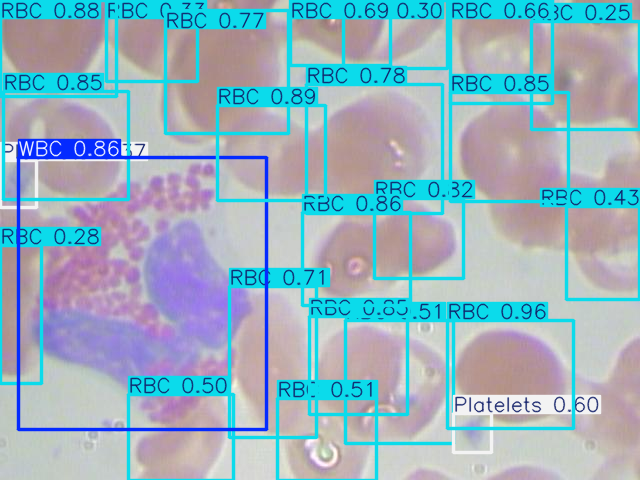

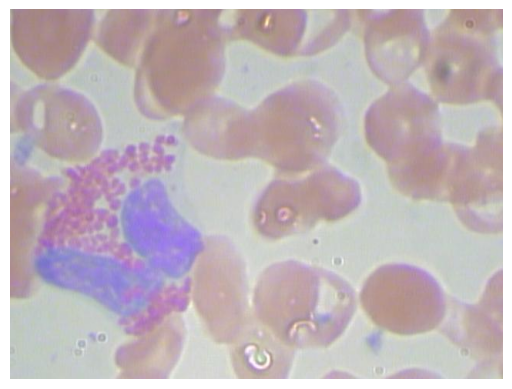

In [13]:
# Load a test image
from PIL import Image
import matplotlib.pyplot as plt

img_path = '/content/BLOOD.jpg'  # Change path to test image
img = Image.open(img_path)

# Predict and show results
results = model(img_path)
# Access the first element of the results list, assuming it's for the single image.
results[0].show()

# Plot image
plt.imshow(img)
plt.axis('off')
plt.show()

In [14]:
model.save('best.pt')


Saving BLOOD.jpg to BLOOD (1).jpg

image 1/1 /content/BLOOD (1).jpg: 480x640 1 WBC, 21 RBCs, 2 Plateletss, 9.1ms
Speed: 1.9ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


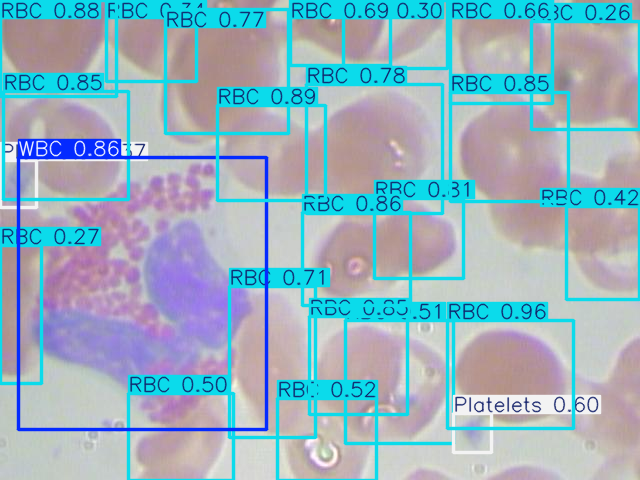

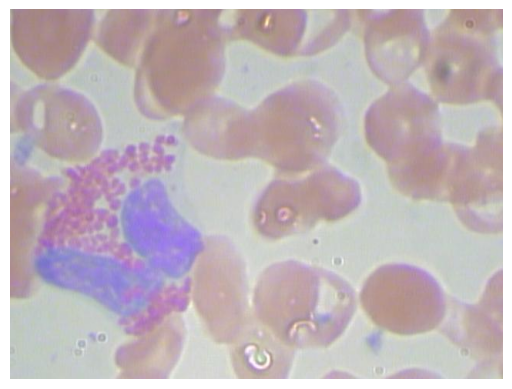

In [15]:
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
from google.colab import files
import io

# Load the trained model
model = YOLO('best.pt')

def upload_and_predict():
    # Use Google Colab's file upload
    uploaded = files.upload()

    if not uploaded:
        print("No file selected!")
        return

    # Get the first uploaded file
    for filename in uploaded:
        # Open the image
        img = Image.open(io.BytesIO(uploaded[filename]))
        break  # Process only the first file

    # Perform prediction
    results = model(filename)  # Use the filename of the uploaded file

    # Display the results
    results[0].show()

    # Plot using matplotlib
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Call the function
upload_and_predict()

In [16]:
from google.colab import files
files.download('best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
from ultralytics import YOLO

# Train the model
model = YOLO('yolov8n.pt')
model.train(data='data.yaml', epochs=10)

# Save the model correctly
model.export(format='torch')  # This saves it as a .pt file


Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

train: Scanning /content/data/labels/train.cache... 291 images, 0 backgrounds, 0 corrupt: 100%|██████████| 291/291 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/labels/val.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.41G      1.409      2.967      1.462         39        640: 100%|██████████| 19/19 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         73        984       0.92      0.126      0.248      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.54G      1.196      1.445      1.283         27        640: 100%|██████████| 19/19 [00:05<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

                   all         73        984      0.851      0.493      0.667      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.54G      1.129      1.165      1.223         44        640: 100%|██████████| 19/19 [00:04<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]

                   all         73        984      0.834      0.635      0.791       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.54G      1.114      1.074      1.201         35        640: 100%|██████████| 19/19 [00:05<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         73        984      0.712      0.662      0.867      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.54G      1.092      1.025      1.179         28        640: 100%|██████████| 19/19 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all         73        984      0.832      0.733      0.896      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.54G      1.083     0.9799      1.163         47        640: 100%|██████████| 19/19 [00:06<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


                   all         73        984      0.844      0.801      0.882      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.54G      1.065     0.9656      1.153         37        640: 100%|██████████| 19/19 [00:04<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         73        984       0.82       0.87      0.902       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.54G      1.043     0.9188      1.136         36        640: 100%|██████████| 19/19 [00:04<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all         73        984      0.833      0.891      0.915      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.54G      1.043     0.8967      1.136         34        640: 100%|██████████| 19/19 [00:05<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all         73        984      0.836      0.907      0.915      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.54G      1.034     0.8773      1.121         25        640: 100%|██████████| 19/19 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

                   all         73        984      0.848      0.897      0.917      0.623



10 epochs completed in 0.019 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


                   all         73        984      0.833       0.89      0.915      0.625
                   WBC         72         75      0.974          1      0.989      0.793
                   RBC         71        850      0.675      0.898      0.875      0.627
             Platelets         33         59      0.851      0.773      0.881      0.455
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/train3
WARNING ⚠️ Invalid export format='torch', updating to format='torchscript'
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (5.9 MB)

TorchScript: starting export with torch 2.6.0+cu124...
TorchScript: export success ✅ 2.0s, saved as 'runs/detect/train3/weights/best.torchscript' (11

'runs/detect/train3/weights/best.torchscript'

Loading /content/runs/detect/train3/weights/best.torchscript for TorchScript inference...

image 1/1 /content/BLOOD.jpg: 640x640 1 WBC, 13 RBCs, 1 Platelets, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


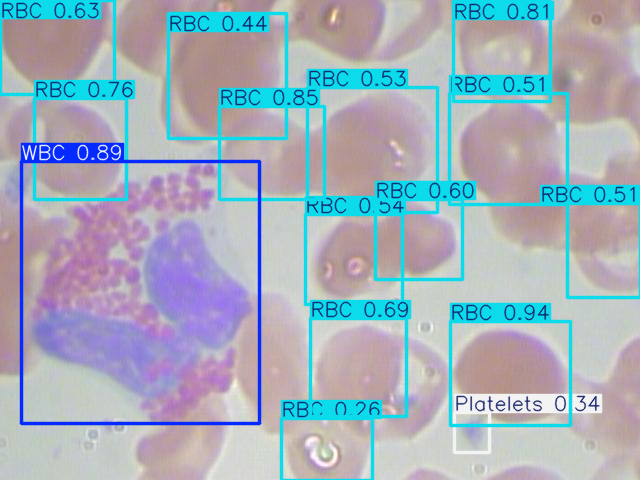

In [25]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

model = YOLO('/content/runs/detect/train3/weights/best.torchscript')
results = model('/content/BLOOD.jpg')
# Access the first element of the results list, assuming it's for the single image.
results[0].show() # Then show the results